In [1]:
import random
import numpy as np
import pygame  # Add this line to import pygame
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import subprocess
import numpy as np
import pickle
from random import sample
from tqdm import tqdm


pygame 2.6.1 (SDL 2.28.4, Python 3.12.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:

class JointAgent:
    # Only works for two agents
    def __init__(self, width, height, draw_radius, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.x1 = random.randint(0, width - 1)
        self.y1 = random.randint(0, height - 1)
        self.x2 = random.randint(0, width - 1)
        self.y2 = random.randint(0, height - 1)
        self.width = width
        self.height = height
        # self.draw_radius = draw_radius # unneeded, too slow
        self.alpha = alpha # learning rate
        self.gamma = gamma # future discount
        self.epsilon = epsilon # epsilon greedy
        self.q_values1 = {} # this is actually the value function for each state
        self.q_values2 = {}
        self.occupancy = {}
        self.previous_state = None
        self.previous_action = None  
        self.possible_actions = ["stay","up", "down", "left", "right"]
        self.rewards_active = ()

    def update_occupancy(self):
        self.occupancy[(self.get_state(0)[0], self.get_state(1)[0])] = 1 + self.occupancy.get((self.get_state(0)[0], self.get_state(1)[0]),0)

    def reset(self):
        self.x1 = random.randint(0, self.width - 1)
        self.y1 = random.randint(0, self.height - 1)
        self.x2 = random.randint(0, self.width - 1)
        self.y2 = random.randint(0, self.height - 1)
        self.rewards_active = ()

    def reset_to_center(self):
        self.x1, self.y1 = (int(self.width/2),int(self.height/2))
        self.x2, self.y2 = (int(self.width/2),int(self.height/2))
        self.rewards_active = ()
    
    def choose_action(self):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(self.possible_actions), random.choice(self.possible_actions)
        else:
            # list all action pairs (e.g., 25)
            action_pairs = [(a1,a2) for a1 in self.possible_actions for a2 in self.possible_actions]
            
            # update
            q_values = [self.get_q_value(0,
                                         self.get_next_state(((self.x1, self.y1), self.rewards_active), a1),
                                         self.get_next_state(((self.x2, self.y2), self.rewards_active), a2)) 
                        for a1,a2 in action_pairs]
            
            # choose a best best action (random because of ties)
            max_indices = np.where(q_values == np.max(q_values))[0]
            idx = random.choice(max_indices)
            action1 = action_pairs[idx][0]
            # update
            q_values = [self.get_q_value(1,
                                         self.get_next_state(((self.x1, self.y1), self.rewards_active),a1),
                                         self.get_next_state(((self.x2, self.y2), self.rewards_active),a2)) 
                        for a1,a2 in action_pairs]
            
            # choose a best best action (random because of ties)
            max_indices = np.where(q_values == np.max(q_values))[0]
            idx = random.choice(max_indices)
            action2 = action_pairs[idx][1]
            
            return action1, action2  

    def get_next_state(self, states, action):
        
        pos, _ = states
        
        if action == "up":
            next_state = (max(0, pos[0]), max(0, pos[1] - 1)), self.rewards_active
        elif action == "down":
            next_state = (max(0, pos[0]), min(self.height - 1, pos[1] + 1)), self.rewards_active
        elif action == "left":
            next_state = (max(0, pos[0] - 1), pos[1]), self.rewards_active
        elif action == "right":
            next_state = (min(self.width - 1, pos[0] + 1), pos[1]), self.rewards_active
        elif action == "stay":
            next_state = (pos[0], pos[1]), self.rewards_active
        return next_state

    def get_q_value(self, idx, state1, state2):
        if idx == 0:
            return self.q_values1.get((state1,state2), 0)
        elif idx == 1:
            return self.q_values2.get((state1,state2), 0)

    def get_state(self,idx):
        if idx == 0:
            return (self.x1, self.y1), self.rewards_active
        elif idx == 1:
            return (self.x2, self.y2), self.rewards_active

    def update_q_value(self, state1, state2, reward1, reward2):
        # Gauss-Seidal Value Iteration
        next_state1 = [self.get_next_state(state1, a) for a in self.possible_actions]
        next_state2 = [self.get_next_state(state2, a) for a in self.possible_actions]
        
        current_state = (self.get_state(0), self.get_state(1))
        
        next_q_values = [self.get_q_value(0,state1,state2) for state1 in next_state1 for state2 in next_state2]
        self.q_values1[current_state] = (1 - self.alpha) * self.get_q_value(0,self.get_state(0),self.get_state(1)) + \
                                               self.alpha * (reward1 + self.gamma * max(next_q_values))
                                               
        next_q_values = [self.get_q_value(1,state1,state2) for state1 in next_state1 for state2 in next_state2]                                                                                     
        self.q_values2[current_state] = (1 - self.alpha) * self.get_q_value(1,self.get_state(0),self.get_state(1)) + \
                                               self.alpha * (reward2 + self.gamma * max(next_q_values))

    def move(self, idx, action):
        if idx == 0:
            if action == "up":
                self.y1 = max(0, self.y1 - 1)
            elif action == "down":
                self.y1 = min(self.height - 1, self.y1 + 1)
            elif action == "left":
                self.x1 = max(0, self.x1 - 1)
            elif action == "right":
                self.x1 = min(self.width - 1, self.x1 + 1)
        elif idx == 1:
            if action == "up":
                self.y2 = max(0, self.y2 - 1)
            elif action == "down":
                self.y2 = min(self.height - 1, self.y2 + 1)
            elif action == "left":
                self.x2 = max(0, self.x2 - 1)
            elif action == "right":
                self.x2 = min(self.width - 1, self.x2 + 1)


In [3]:

def train_qval(agent, epsilon, grid_size, num_frames, target_reward1, target_reward2, together_reward, travel_reward):
    """
    Train the agent using the specified environment settings.
    """
    
    reward_place_to_coord = {
        () : (),
        ('up') : ((grid_size//2,grid_size-1)),
        ('right') : ((grid_size-1,grid_size//2)),
        ('down') : ((grid_size//2,0)),
        ('left') : ((0,grid_size//2)),
        ('up','right') : ((grid_size//2,grid_size-1),(grid_size-1,grid_size//2)),
        ('right','down') : ((grid_size-1,grid_size//2),(grid_size//2,0)),
        ('down','left') : ((grid_size//2,0),(0,grid_size//2)),
        ('up','left') : ((0,grid_size//2),(grid_size//2,grid_size-1)),
        ('up','down') : ((grid_size//2,grid_size-1),(grid_size//2,0)),
        ('right','left') : ((grid_size-1,grid_size//2),(0,grid_size//2)),
        ('up','right','down') : ((grid_size//2,grid_size-1),(grid_size-1,grid_size//2),(grid_size//2,0)),
        ('right','down','left') : ((grid_size-1,grid_size//2),(grid_size//2,0),(0,grid_size//2)),
        ('up','down','left') : ((grid_size//2,0),(0,grid_size//2),(grid_size//2,grid_size-1)),
        ('up','right','left') : ((0,grid_size//2),(grid_size//2,grid_size-1),(grid_size-1,grid_size//2)),
        ('up','right','down','left') : ((grid_size//2,grid_size-1),(grid_size-1,grid_size//2),(grid_size//2,0),(0,grid_size//2))
    }  
    
    def train_regime(agent, regime, iteration_multiplier=1):
        
        rewards_activated_series = {'a1' : [], 'a2' : []}
        rewards_collected_series = {'a1' : [], 'a2' : []}
        cumulative_reward_series = {'a1' : [], 'a2' : []}
        consecutive_noreward = 0
        rp  = []
        sq = []
        rewards_collected_count = 0
        a1_rewards_activated_count = 0
        a2_rewards_activated_count = 0
        true_reward_locations = ('right','left')
        for frame_count in tqdm(range(num_frames * iteration_multiplier)):
            
            agent.epsilon = (0.4-epsilon)/(num_frames * iteration_multiplier) * frame_count + epsilon
        
            reward1 = reward2 = 0
            rewards_collected_count = 0
            a1_rewards_activated_count = a2_rewards_activated_count = 0
            
            # reset if no reward for a long time
            if consecutive_noreward > 50:
                agent.reset()
                consecutive_noreward = 0
                if regime == 0:
                    true_reward_locations = ('right','left')
                if regime == 1:
                    true_reward_locations = ('right','left')
                if regime == 2:
                    true_reward_locations = ('up','down')
                if regime == 3:
                    true_reward_locations = sample([('up','right'),('right','down'),('down','left'),('up','left'),('right','left'),('up','down')], 1)[0]
            
            # Take set difference to determine the other
            non_reward_locations = tuple(set(['up','right','down','left']) - set(true_reward_locations))
            
            # Sort acorrding to scheme up right down left (clockwise)
            non_reward_locations = tuple(sorted(non_reward_locations, key=lambda x: ['up','right','down','left'].index(x)))
            
            # Agent chooses action
            action1, action2 = agent.choose_action()
            sq.append([agent.get_state(0), agent.get_state(1), action1, action2, reward_place_to_coord[agent.rewards_active]])
            if hasattr(agent, 'explore') and not agent.explore:
                rp.append([agent.get_state(0), agent.get_state(1), action1, action2])
                
            agent.move(0, action1)
            agent.move(1, action2)
            agent.update_occupancy()
            state1 = agent.get_state(0)
            pos1, _ = state1
            state2 = agent.get_state(1)
            pos2, _ = state2
            
            center_pos = (grid_size // 2, grid_size  // 2)
            a1_at_center = pos1 == center_pos
            a2_at_center = pos2 == center_pos
            if a1_at_center and not agent.rewards_active: 
                if regime == 0:
                    agent.rewards_active = true_reward_locations
                    reward1 += target_reward1
                    reward2 += target_reward2
                    consecutive_noreward = 999 # dummy number used to reset
                if regime == 1 or regime == 2 or regime == 3:
                    agent.rewards_active = true_reward_locations
                    a1_rewards_activated_count = 1
                    # sq.append([state1, state2, None, None, reward_place_to_coord[agent.rewards_active]])
                
            if a2_at_center and not agent.rewards_active:
                if regime == 0:
                    agent.rewards_active = true_reward_locations
                    reward1 += target_reward1
                    reward2 += target_reward2
                    consecutive_noreward = 999 # dummy number used to reset
                if regime == 1 or regime == 2 or regime == 3:
                    agent.rewards_active = true_reward_locations
                    a2_rewards_activated_count = 1
                    # sq.append([state1, state2, None, None, reward_place_to_coord[agent.rewards_active]])

            
            #print(reward_place_to_coord[agent.rewards_active])
            #print(reward_place_to_coord[agent.rewards_active])
            
            # Calculate reward based on the next state
            if ((agent.rewards_active and 
                 pos1 == reward_place_to_coord[true_reward_locations][0] and 
                 pos2 == reward_place_to_coord[true_reward_locations][0]) or 
                (agent.rewards_active and 
                 pos1 == reward_place_to_coord[true_reward_locations][1] and 
                 pos2 == reward_place_to_coord[true_reward_locations][1])):
                # sq.append([state1, state2, None, None, reward_place_to_coord[agent.rewards_active]])
                if regime == 1 or regime == 2 or regime == 3:
                    reward1 += target_reward1
                    reward2 += target_reward2
                    reward_collected_count = 1
                    consecutive_noreward = 999 # dummy number used to reset
            
            if ((agent.rewards_active and 
                 pos1 == reward_place_to_coord[non_reward_locations][0] and 
                 pos2 == reward_place_to_coord[non_reward_locations][0]) or 
                (agent.rewards_active and 
                 pos1 == reward_place_to_coord[non_reward_locations][1] and 
                 pos2 == reward_place_to_coord[non_reward_locations][1])):
                consecutive_noreward = 999 # dummy number used to reset
        
            if pos1 == pos2:
                reward1 += together_reward
                reward2 += together_reward
                
            reward1 += travel_reward # energy loss
            reward2 += travel_reward
            consecutive_noreward += 1
                
            # Update Q-value with Bellman Equation
            if agent.previous_state is not None:
                agent.update_q_value(agent.get_state(0), agent.get_state(1), reward1, reward2)
            agent.previous_state = (agent.get_state(0), agent.get_state(1))
            agent.previous_action = (action1, action2)
            agent.previous_q_values = agent.q_values2.copy()
            frame_count += 1
            
            # clear replay buffer
            if len(rp) > 5000: 
                if agent.predictor is not None:
                    rp_state1 = [ele[0] for ele in rp]
                    rp_state2 = [ele[1] for ele in rp]
                    rp_action2 = [ele[3] for ele in rp]
                    agent.build_predictor(np.concatenate((rp_state1,rp_state2),axis=1), np.ravel(rp_action2))
                rp = []
            
            rewards_activated_series['a1'].append(a1_rewards_activated_count)
            rewards_activated_series['a2'].append(a2_rewards_activated_count)
            rewards_collected_series['a1'].append(rewards_collected_count)
            rewards_collected_series['a2'].append(rewards_collected_count)
            cumulative_reward_series['a1'].append(reward1)
            cumulative_reward_series['a2'].append(reward2)
        
        return agent, rewards_activated_series, rewards_collected_series, cumulative_reward_series, sq
    
    training_regimes = [0, 1, 2, 3]
    multipliers = [1, 1, 1, 1]
    regime_details = {regime : multiplier for regime, multiplier in zip(training_regimes, multipliers)}
    rewards_activated = []
    rewards_collected = []
    cumulative_rewards = []
    sqs = []
    for regime, multiplier in regime_details.items():
        agent, reward_activated_series, reward_time_series, cumulative_reward_series, sq = train_regime(agent, regime, multiplier)
        rewards_activated.append(reward_activated_series)
        rewards_collected.append(reward_time_series)
        cumulative_rewards.append(cumulative_reward_series)
        print(len(agent.q_values1))
        sqs.append(sq)
    
    return agent, rewards_activated, rewards_collected, cumulative_rewards, sqs



In [4]:
# %run main.py --train --total_ep 1_000_000 --grid_size 11 --epsilon 0.99 --save_dir {save_dir} --target_reward1 20 --target_reward2 20 --together_reward 0 --travel_reward -1 --prior_q experiments/priors/OneDiffusion/q_val.pkl 
# Set up the environment
grid_size = 5
num_frames = 1_000
epsilon = 0.99
target_reward1 = 20
target_reward2 = 20
together_reward = 0
travel_reward = -1

In [5]:
agent = JointAgent(width=grid_size, height=grid_size, draw_radius=20, alpha=0.1, gamma=0.9, epsilon=0.99)

agent, rewards_activated, rewards_collected, cumulative_rewards, sqs = train_qval(agent, epsilon, grid_size, num_frames, target_reward1, target_reward2, together_reward, travel_reward)

100%|██████████| 1000/1000 [00:00<00:00, 31047.07it/s]


519


100%|██████████| 1000/1000 [00:00<00:00, 27704.92it/s]


830


100%|██████████| 1000/1000 [00:00<00:00, 27990.76it/s]


1303


100%|██████████| 1000/1000 [00:00<00:00, 26379.60it/s]

1734


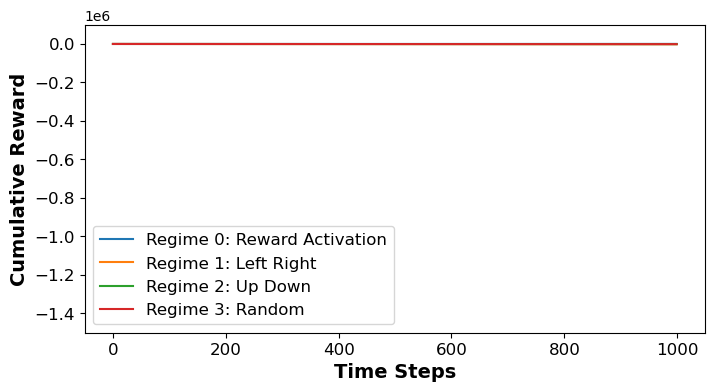

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
regime_names = ['Regime 0: Reward Activation', 'Regime 1: Left Right', 'Regime 2: Up Down', 'Regime 3: Random']
for regime, reward_history in enumerate(cumulative_rewards):
    rh = np.array(reward_history["a1"])
    crh = np.cumsum(rh, axis=0)
    plt.plot(crh, label=regime_names[regime])
plt.legend(fontsize=12)
plt.ylabel('Cumulative Reward', fontsize=14, fontweight='bold')
plt.xlabel('Time Steps', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(-1.5e6, 0.1e6)
plt.legend(loc="lower left", fontsize=12)
plt.show()

In [8]:
# pickle q_values1 and q_values2
# with open('q_values1.pkl', 'wb') as f:
#     pickle.dump(agent.q_values1, f)
# with open('q_values2.pkl', 'wb') as f:
#     pickle.dump(agent.q_values2, f)
# # pickle occupancy
# with open('rewards_activated.pkl', 'wb') as f:
#     pickle.dump(rewards_activated, f)
# with open('rewards_collected.pkl', 'wb') as f:
#     pickle.dump(rewards_collected, f)
# with open('cumulative_rewards.pkl', 'wb') as f:
#     pickle.dump(cumulative_rewards, f)
# with open('sqs.pkl', 'wb') as f:
#     pickle.dump(sqs, f)